In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
import keras
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import random
from sklearn.model_selection import KFold

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

### Functions

In [3]:
def build_data_arrays(SR, SB, gaiadata2):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec
    
    Xad = gaiadata2[:, 3]-center_ra
    Yad = gaiadata2[:, 2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5]]
    gaiadata2 = np.c_[gaiadata2[:,0],gaiadata2[:,1], Xad, Yad, gaiadata2[:,4],gaiadata2[:,5]]
    
    return SR, SB, gaiadata2

In [4]:
threshold_arr_size = 10000

In [5]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [6]:
def find_SR_SB_pointers(pointers, increment, data_arr, start_point, end_point):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

In [7]:
def angular_distance(angle1,angle2):
    # inputs are np arrays of [ra,dec]
    deltara=np.minimum(np.minimum(np.abs(angle1[:,0]-angle2[:,0]+360),np.abs(angle1[:,0]-angle2[:,0])),\
                          np.abs(angle1[:,0]-angle2[:,0]-360))
    deltadec=np.abs(angle1[:,1]-angle2[:,1])
    return np.sqrt(deltara**2+deltadec**2)

In [8]:
#function from David's file via_machinae.py
def FilterGD1(stars):
    gd1stars=np.zeros(len(stars))
    for x in allgd1stars:
        ra=x[0]
        dec=x[1]
        pmra=x[2]
        pmdec=x[3]
    
        foundlist=angular_distance(np.dstack((stars[:,3],stars[:,2]))[0],np.array([[ra,dec]]))
        foundlist=np.sqrt(foundlist**2+(stars[:,0]-pmdec)**2+(stars[:,1]-pmra)**2)   
        foundlist=foundlist<.0001
        if len(np.argwhere(foundlist))>1:
            print(foundlist)
        if len(np.argwhere(foundlist))==1:
            gd1stars+=foundlist
    gd1stars=gd1stars.astype('bool')
    return gd1stars,stars[gd1stars]

In [9]:
def make_fractional_background(all_data, fraction):
    num = fraction*100
    frac_background = []
    for i in range(len(all_data)):
        if all_data[i][6]:
            frac_background.append(all_data[i])
        else:
            if random.randint(0, 100) < num:
                frac_background.append(all_data[i])
    frac_background = np.array(frac_background)
    frac_background = frac_background[:, :6]
    return frac_background

In [10]:
def split(data, num_splits):
    res = []
    curr = 0
    diff = len(data)//num_splits
    while curr < num_splits:
        res.append(data[curr*diff:(curr+1)*diff])
        curr += 1
    return res

### Loading data and preprocessing

In [11]:
datafile = '/data0/users/bpnachman/Gaia/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy'
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2 = np.array(gaiadata[:,[9,8,6,7,4,5]]).astype('float32') 
#pm_lat, pm_lon_coslat, lon, lat, color, mag
allgd1stars = np.load('gd1_stars.npy')
is_stream_arr, gaiadata3 = FilterGD1(gaiadata)

new_gaiadata = []
for i in range(len(gaiadata)):
    temp = np.append(gaiadata[i], is_stream_arr[i])
    new_gaiadata.append(temp)

In [12]:
gaiadata = new_gaiadata
gaiadata = np.array(gaiadata)

In [13]:
#switch 0 and 1
gaiadata2 = np.array(gaiadata[:,[8,9,6,7,4,5,10]]).astype('float32') 
gaiadata3 = np.array(gaiadata3[:,[8,9,6,7,4,5]]).astype('float32') 

In [14]:
gaiadata2 = gaiadata2[(np.abs(gaiadata2[:,0]) > 2) + (np.abs(gaiadata2[:,1]) > 2)] 
gaiadata2 = gaiadata2[(gaiadata2[:,4]>0.5) * (gaiadata2[:,4]<1)]

gaiadata3 = gaiadata3[(np.abs(gaiadata3[:,0]) > 2) + (np.abs(gaiadata3[:,1]) > 2)] 
gaiadata3 = gaiadata3[(gaiadata3[:,4]>0.5) * (gaiadata3[:,4]<1)]

# k-folding

In [15]:
#next steps: k folding, start with k = 2 (sk learn maybe has a function to split data into k pieces)
#for k > 2:
#1/k should be test, 1/k should be validation (k-1 choices), average amongst the k-1 choices, k-2/k for training, 
#loop within this structure 

#validation set -> use to pick the best model, lowest validation loss

In [16]:
frac_background = make_fractional_background(gaiadata2, 0.1)


SR = frac_background[(frac_background[:,0] > -10)*(frac_background[:,0] < -8)]
SB = frac_background[(frac_background[:,0] > -11)*(frac_background[:,0] < -10)+(frac_background[:,0] > -8)*(frac_background[:,0] < -7)]
pointer1 = -10
pointer2 = -8
stream = gaiadata3

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]

In [17]:
#split data into 5 sets
num_splits = 5
split_X = split(X_scaled, num_splits)
split_Y = split(Y, num_splits)

In [18]:
epochs = 200
preds_overall = []
X_test_unscaled_all = []

for test_counter in range(num_splits):
    print('outer loop')
    X_test, Y_test = split_X[test_counter], split_Y[test_counter]
    
    preds_average = []
    
    for val_counter in range(num_splits):
        print('middle loop')
        if val_counter != test_counter:
            X_val, Y_val = split_X[val_counter], split_Y[val_counter]
            
            
            X_train = []
            Y_train = []
            for train_counter in range(num_splits):
                if train_counter != test_counter and train_counter != val_counter:
                    if len(X_train) == 0:
                        X_train = split_X[train_counter]
                        Y_train = split_Y[train_counter]
                    else:
                        X_train = np.concatenate((X_train, split_X[train_counter]))
                        Y_train = np.concatenate((Y_train, split_Y[train_counter]))
                    
                    

                    
            preds_best_loop = []
            num_loops = 10
            min_loss = None
            
            
            for curr_index in range(num_loops):
                print('inner loop')
    
                model = Sequential()
                initializer =tf.keras.initializers.glorot_normal()
                model.add(Dense(256, input_dim=5, activation='relu', bias_initializer = initializer)) 
                model.add(Dropout(0.25))
                model.add(Dense(256, activation='relu', bias_initializer = initializer))
                model.add(Dropout(0.25))
                model.add(Dense(256, activation='relu', bias_initializer = initializer))
                model.add(Dropout(0.25))
                model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
                optimizer = keras.optimizers.Adam(lr=1e-4)
                model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                history = model.fit(X_train[:,1:],Y_train, epochs=epochs, batch_size=200, 
                                    validation_data=(X_val[:,1:], Y_val), verbose = 0) 

                preds_curr = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
                curr_loss = history.history['val_loss'][epochs - 1]
                print(curr_loss)
                
                if not min_loss or curr_loss < min_loss:
                    preds_best_loop = preds_curr
                    min_loss = curr_loss
                    
            if len(preds_average) == 0:
                preds_average = preds_best_loop
            else:
                preds_average += preds_best_loop
            
            
                
#                 loss_average += history.history['val_loss'][epochs-1]
                
#                 if len(preds_average) == 0:
#                     preds_average = preds_curr
#                 else:
#                     preds_average += preds_curr

                
#             loss_average /= num_loops
#             preds_average = np.array([elem/num_loops for elem in preds_average])
#             if loss_average < min_loss:
#                 best_val_index = val_counter
#                 min_loss = loss_average
#                 preds_best_val = preds_average
    
    preds_overall.extend(preds_average)
    print(preds_overall)
    X_test_unscaled_all.extend(myscalar.inverse_transform(X_test))

        





outer loop
middle loop
middle loop
inner loop
2.8634653141900306
inner loop
2.7029805865760177
inner loop
2.99586829848455
inner loop
2.9147086109174296
inner loop
3.0856020862424303
inner loop
2.81639204360387
inner loop
2.9383055642941156
inner loop
3.0207903241828578
inner loop
2.775219098477925
inner loop
2.96587434045144
middle loop
inner loop
0.9068968646057979
inner loop
0.975417642624675
inner loop
0.9406606210782102
inner loop
0.944687577057551
inner loop
0.9052015592696604
inner loop
0.9186134043131513
inner loop
0.9194351751909329
inner loop
0.9247184514141406
inner loop
0.96601312840318
inner loop
0.9113956350173917
inner loop
0.7669676381788649
inner loop
0.8657006331665046
inner loop
0.9473022315383058
inner loop
0.8234233637667631
inner loop
0.8258145473752357
middle loop
inner loop
1.7893427682064227
inner loop
1.8959009256734372
inner loop
1.9161400024816204
inner loop
1.8371053791772904
inner loop
1.8586213042633095
inner loop
1.7711479862699258
inner loop
1.875911812

5.515067071858147
inner loop
6.477995500233495
inner loop
6.019043885278661
inner loop
5.81178493564357
inner loop
6.109514252196723
inner loop
5.007078399706654
inner loop
5.050673814671812
inner loop
6.292910143039067
inner loop
6.027714305767864
inner loop
4.955680501955632
middle loop
middle loop
inner loop
4.414074155660527
inner loop
4.465450327140007
inner loop
4.330120999261951
inner loop
4.291214189824162
inner loop
4.35647621061921
inner loop
4.407698445457407
inner loop
4.42113535793831
inner loop
4.373056413560071
inner loop
4.4098910512205505
inner loop
4.606453221395397
middle loop
inner loop
1.40271877704991
inner loop
1.4039149917756775
inner loop
1.3150173114781456
inner loop
1.3302653312279349
inner loop
1.4234404545230042
inner loop
1.379007706038534
inner loop
1.384886803110205
inner loop
1.3582854320395306
inner loop
1.4152798999375351
inner loop
1.45799984929927
middle loop
inner loop
1.2973729603175488
inner loop
1.2590616656803257
inner loop
1.2637983780609765
i

1.972564356494616
inner loop
2.1031465926077484
inner loop
1.9814406838283813
inner loop
1.9569812047087873
inner loop
2.013444720033263
inner loop
2.0803355379290345
inner loop
2.0361479071617934
inner loop
1.9737653595022384
inner loop
2.0712986577879464
inner loop
1.960050676961151
middle loop
inner loop
6.412128119828033
inner loop
6.207645905613394
inner loop
6.2466924693198855
inner loop
5.929428324671139
inner loop
6.480923569071202
inner loop
6.596901882310523
inner loop
6.1043268727812094
inner loop
6.14933197342875
inner loop
6.150445445930423
inner loop
6.176236734059178
middle loop
middle loop
inner loop
4.178642270526676
inner loop
4.334834373370759
inner loop
4.552876177730448
inner loop
4.363486985651544
inner loop
4.255629256254127
inner loop
4.432961553764182
inner loop
4.02271134100356
inner loop
4.0401221605602915
inner loop
4.0954797556600155
inner loop
3.906769522360883
middle loop
inner loop
1.657640605635001
inner loop
1.5774036397578655
inner loop
1.725214622164

2.198615577642843
inner loop
2.078579393814016
inner loop
2.0142817659765657
inner loop
2.048371642550405
inner loop
2.1138008690607135
inner loop
1.9793644495983431
inner loop
2.1915890234794584
inner loop
1.7850443144958974
inner loop
2.0289083890850317
inner loop
1.928958293949518
middle loop
inner loop
1.3109798690810435
inner loop
1.2472869726079283
inner loop
1.2131054664849226
inner loop
1.2901095678804286
inner loop
1.2354122905989606
inner loop
1.2721475758459686
inner loop
1.2425815676552678
inner loop
1.2051415044710254
inner loop
1.1663238721616584
inner loop
1.1938797030582153
middle loop
inner loop
3.2911014149090074
inner loop
3.313812857053726
inner loop
3.239070596380016
inner loop
3.26436925802465
inner loop
3.2498197906810686
inner loop
3.167013817576409
inner loop
3.209844317504857
inner loop
3.09011359259196
inner loop
2.9710314802756055
inner loop
3.1627685884415953
middle loop
middle loop
inner loop
10.047526368440762
inner loop
10.469340137866066
inner loop
10.5

outer loop
middle loop
inner loop
3.0401462414424163
inner loop
3.034361913787622
inner loop
3.2795689602608804
inner loop
3.1083487489282025
inner loop
3.1806866026449567
inner loop
3.3049985748746455
inner loop
3.2184590148683525
inner loop
3.2273367218401954
inner loop
3.2585972019618694
inner loop
3.178595152070823
middle loop
inner loop
1.1245005704102933
inner loop
1.0014709111848794
inner loop
1.0523318898667733
inner loop
1.0891200444841667
inner loop
1.1768730206574352
inner loop
1.1914137872369688
inner loop
1.0910341945065976
inner loop
0.9619676404388954
inner loop
1.1368983231491199
inner loop
1.0663510204673723
middle loop
inner loop
1.4320080219740388
inner loop
1.4311049878849609
inner loop
1.4659607894939453
inner loop
1.4481613373574718
inner loop
1.2292924712614726
inner loop
1.4207628449578087
inner loop
1.4048264141712625
inner loop
1.267506746393861
inner loop
1.2557481647446234
inner loop
1.2723914727026078
middle loop
inner loop
5.208113600499139
inner loop
5.34

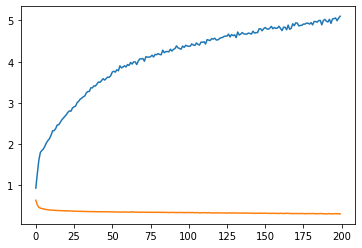

In [23]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [19]:
preds_overall = np.array(preds_overall)
stars_passing_cut = []
preds_sorted = preds_overall[np.argsort(preds_overall[:,0])]
X_test_unscaled_all = np.array(X_test_unscaled_all)
X_test_sorted = X_test_unscaled_all[np.argsort(preds_overall[:,0])]
X_test_sorted = X_test_sorted[(X_test_sorted[:,0] > pointer1) * (X_test_sorted[:,0] < pointer2)]

stars_passing_cut = X_test_sorted[len(X_test_sorted) - 100:]

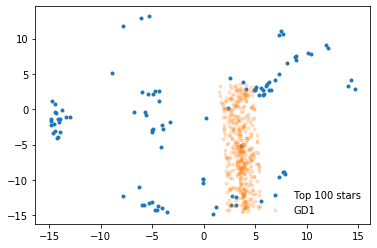

In [20]:
plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.', label = 'Top 100 stars')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', alpha = 0.2, label = 'GD1')
plt.legend(frameon = False)
plt.show()

In [ ]:
import time

In [ ]:
start_time = time.time()

In [ ]:
#bigger batch size, lower learning rate, more epochs

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

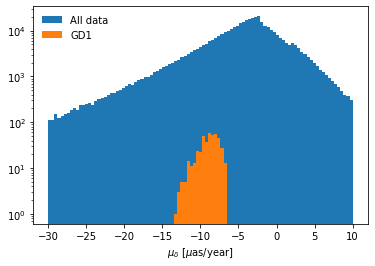

In [22]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

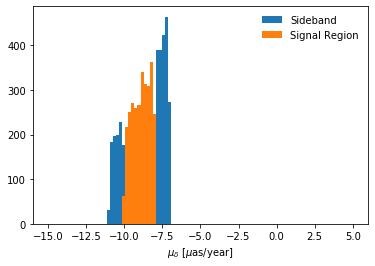

In [25]:
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-15,5,100),label="Sideband")
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-15,5,100),label="Signal Region")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")